# Predicting Hypoxic Ischemic Encephalopathy from Collaborative Perinatal Project using ML

In [1]:
# upgrade tensorflow
! pip install grpcio==1.24.3
! pip install tensorflow==2.0.0

# Load the TensorBoard notebook extension
%load_ext tensorboard

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import brier_score_loss, roc_curve, auc
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white")

     |████████████████████████████████| 2.2MB 9.8MB/s eta 0:00:01
  Found existing installation: grpcio 1.23.0
    Uninstalling grpcio-1.23.0:
      Successfully uninstalled grpcio-1.23.0
     |████████████████████████████████| 86.3MB 582kB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 24.7MB/s eta 0:00:01
     |████████████████████████████████| 71kB 16.3MB/s eta 0:00:01
     |████████████████████████████████| 450kB 29.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 16.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 17.8MB/s eta 0:00:01
     |████████████████████████████████| 133kB 31.1MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.6MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=336ff55c2a160e105a9b8242cc842bea4703f1e52b67dfb19f8cd9c4a44a9923
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for 

In [2]:
def get_feature_importance(pred, out):
    # fit RF with all variables using five-fold CV
    clf = RandomForestClassifier(random_state=0, n_estimators=100)
    scores = cross_val_score(clf, pred.to_numpy(), out.to_numpy(), cv=5, scoring='roc_auc')
    
    # get feature importance measures
    clf.fit(pred, out.to_numpy())
    fi = pd.DataFrame(data={'predictor' : pred.columns, 'feature_importance': clf.feature_importances_})
    
    return fi

In [3]:
def fit(clf, x_train, y_train, x_test, y_test):   
    # train model
    clf.fit(x_train, y_train)
    
    # calculate probabilities for test data
    y_test_pred = clf.predict_proba(x_test)[:, 1]
    
    # calculate roc auc metric
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    # calculate brier loss for probability accuracy
    brier_loss = brier_score_loss(y_test, y_test_pred)
    
    print("ROC AUC: {}\nBrier loss: {}".format(np.round(roc_auc, 3), np.round(brier_loss, 3)))
    
    return y_test_pred

In [30]:
def fit_nn(model, x_train, y_train, x_test, y_test):
    print("x_train n={} y_train n={} x_test n={} y_test n={}".format(len(x_train), len(y_train), len(x_test), len(y_test)))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    
    # train model
    model.fit(tf.convert_to_tensor(x_train.to_numpy(), np.float32), tf.convert_to_tensor(y_train.to_numpy(), np.float32), epochs=30)
    
    # predict test probabilities
    y_test_pred = model.predict(tf.convert_to_tensor(x_test.to_numpy(), np.float32))
    
    # calculate roc auc metric
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    # calculate brier loss for probability accuracy
    brier_loss = brier_score_loss(y_test.to_numpy(), y_test_pred)
    
    print("ROC AUC: {}\nBrier loss: {}".format(np.round(roc_auc, 3), np.round(brier_loss, 3)))
    
    return y_test_pred

In [5]:
def recursive_feature_elimination_rf(train_x, train_y, test_x, test_y):
    estimator = RandomForestClassifier(random_state=0, n_estimators=100)
    selector = RFE(estimator, 50, step=1)
    selector = selector.fit(train_x.to_numpy(), train_y.to_numpy())
    return train_x[train_x.columns[selector.support_]], train_y, test_x[train_x.columns[selector.support_]], test_y

In [6]:
def process_data(df, numeric_features, means, stds):
    
    # normalise continuous variables
    for i, f in enumerate(numeric_features):
        if f in df.columns:
            df[f] = (df[f] - means[i]) / stds[i]
        
    return df

## Read in data
The first(A) is one with all variables with >5% missing values removed, the second(B) is imputed form the most recent complete data-point prior to that birth and the third(C) is imputed using mode values

Derived variables are:
- _cohort – Either 1 (born in the first deriving cohort) or 0 (in the second, testing cohort)
- _hie – 1 for HIE, 0 for not
- _id
- _lapgar – 1 for a low Apgar score, 0 for not
- _ne – Another measure of brain injury (not used at present)
- _neonataldeath – Not used at present
- _perinataldeath – 1 for perinatal death; 0 for not
- _resus – 1 for resus at birth, and 0 for not
- _stillborn – Not used at present
- _yearofbirth -  Year of birth

First letter is either a (antenatal), g (growth) or I (intrapartum) variable
Second letter is type of entry; c (categorical), o(ordinal) or l(linear)
Then _NAME (most have one given)
Then _#### - number of were extraction was performed on the [Variable File]("3. Index_Variable File_304.2ADV3A.pdf")

In [7]:
# read in data from DO
dat = pd.read_stata("data/1_2_3_4A._Done.dta")

In [8]:
# sep cols
antenatal = []
antenatal_growth = []
antenatal_intrapartum = []
categorical = []
ordinal = []
linear = []

for col in dat.columns:
    if col[0] == "_":
        continue
    if col[0] == "a":
        antenatal.append(col)
        antenatal_growth.append(col)
        antenatal_intrapartum.append(col)
    if col[0] == "g":
        antenatal_growth.append(col)
    if col[0] == "i":
        antenatal_intrapartum.append(col)
    if col[1] == "c":
        categorical.append(col)
    if col[1] == "o":
        ordinal.append(col)
    if col[1] == "l":
        linear.append(col)

In [9]:
# set fields correctly
outcomes = ['_hie', '_lapgar', '_perinataldeath', '_resus']
dat[categorical] = dat[categorical].astype('category')
dat[outcomes] = dat[outcomes].astype('category')

In [10]:
# split test and train
test = dat[dat['_cohort'] == 0]
train = dat[dat['_cohort'] == 1]

## get mean and SD for **training** dataset to standardise variables (where needed)
desc = train[linear].describe()
means = np.array(desc.T['mean'])
stds = np.array(desc.T['std'])

def split_data(df, x_cols, y_col):
    x = df[x_cols + [y_col]]
    x = x.dropna(axis='index')
    y = x.pop(y_col)
    return x, y

## Models

All(?) we need from the ML model is one which takes the outcomes (HIE (Primary outcome), Low Apgar, Perinatal Death and Resus) and builds 3 prediction models. First is only antenatal variables (a*), then next is antenatal and growth (a* and g*) and then antenatal and intrapartum (a* and i*). From each model the idea to produce a prediction score from cohort 1, and apply to cohort 0, derive an ROC/AUC score for the prediction, creating a variable containing which deciles of risk the infant is placed in (1-10) – in order to compare with the other models being developed.

### Antenatal

#### HIE

##### Feature selection

In [11]:
# split out data
train_x, train_y = split_data(train, antenatal, '_hie')
test_x, test_y = split_data(test, antenatal, '_hie')

In [12]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

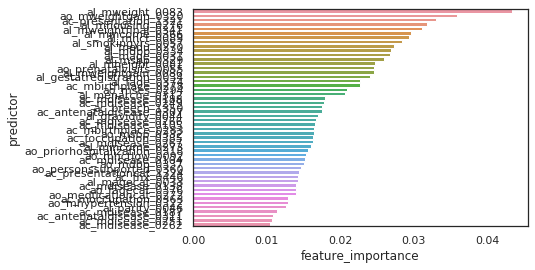

In [13]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [18]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=50000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.682
Brier loss: 0.005


##### Random forest

In [19]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.58
Brier loss: 0.005


##### Neural net

In [20]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [33]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6321 y_train n=6321 x_test n=9356 y_test n=9356
Train on 6321 samples
Epoch 1/30
6321/6321 [==============================] - 1s 171us/sample - loss: 0.4660 - AUC: 0.5011
Epoch 2/30
6321/6321 [==============================] - 0s 65us/sample - loss: 0.0657 - AUC: 0.5411
Epoch 3/30
6321/6321 [==============================] - 0s 66us/sample - loss: 0.0558 - AUC: 0.5738
Epoch 4/30
6321/6321 [==============================] - 0s 72us/sample - loss: 0.0624 - AUC: 0.6540
Epoch 5/30
6321/6321 [==============================] - 0s 70us/sample - loss: 0.0538 - AUC: 0.6667
Epoch 6/30
6321/6321 [==============================] - 0s 69us/sample - loss: 0.0673 - AUC: 0.6384
Epoch 7/30
6321/6321 [==============================] - 0s 69us/sample - loss: 0.0484 - AUC: 0.6782
Epoch 8/30
6321/6321 [==============================] - 0s 69us/sample - loss: 0.0459 - AUC: 0.7340
Epoch 9/30
6321/6321 [==============================] - 0s 73us/sample - loss: 0.0411 - AUC: 0.7775
Epoch 10/30
6321/63

In [32]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6321 y_train n=6321 x_test n=9356 y_test n=9356
Train on 6321 samples
Epoch 1/30
6321/6321 [==============================] - 1s 138us/sample - loss: 0.3497 - AUC: 0.5346
Epoch 2/30
6321/6321 [==============================] - 0s 76us/sample - loss: 0.0947 - AUC: 0.5365
Epoch 3/30
6321/6321 [==============================] - 0s 72us/sample - loss: 0.1121 - AUC: 0.6152
Epoch 4/30
6321/6321 [==============================] - 0s 75us/sample - loss: 0.1277 - AUC: 0.5127
Epoch 5/30
6321/6321 [==============================] - 0s 67us/sample - loss: 0.0648 - AUC: 0.6363
Epoch 6/30
6321/6321 [==============================] - 0s 71us/sample - loss: 0.0717 - AUC: 0.5696
Epoch 7/30
6321/6321 [==============================] - 0s 73us/sample - loss: 0.0722 - AUC: 0.6656
Epoch 8/30
6321/6321 [==============================] - 0s 67us/sample - loss: 0.0586 - AUC: 0.7230
Epoch 9/30
6321/6321 [==============================] - 0s 69us/sample - loss: 0.0635 - AUC: 0.6520
Epoch 10/30
6321/63

In [31]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6321 y_train n=6321 x_test n=9356 y_test n=9356
Train on 6321 samples
Epoch 1/30
6321/6321 [==============================] - 1s 178us/sample - loss: 0.1429 - AUC: 0.5265
Epoch 2/30
6321/6321 [==============================] - 0s 72us/sample - loss: 0.0874 - AUC: 0.5750
Epoch 3/30
6321/6321 [==============================] - 0s 77us/sample - loss: 0.0738 - AUC: 0.6007
Epoch 4/30
6321/6321 [==============================] - 0s 75us/sample - loss: 0.0702 - AUC: 0.6102
Epoch 5/30
6321/6321 [==============================] - 0s 73us/sample - loss: 0.0678 - AUC: 0.6091
Epoch 6/30
6321/6321 [==============================] - 0s 73us/sample - loss: 0.0457 - AUC: 0.7269
Epoch 7/30
6321/6321 [==============================] - 0s 75us/sample - loss: 0.0501 - AUC: 0.7705
Epoch 8/30
6321/6321 [==============================] - 0s 79us/sample - loss: 0.0440 - AUC: 0.7536
Epoch 9/30
6321/6321 [==============================] - 0s 78us/sample - loss: 0.0450 - AUC: 0.7194
Epoch 10/30
6321/63

## Perinatal Death

## Low Apgar

## Resus